In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [15]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [16]:
# Loading the data
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic/test.csv')

print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("\nTraining Data Columns:", train_data.columns.tolist())


Training Data Shape: (891, 12)
Test Data Shape: (418, 11)

Training Data Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [17]:
# initial data exploration
print("\nFirst few entries:")
display(train_data.head())
print("\nDataset Info:")
display(train_data.info())
print("\nNumerical Features Summary:")
display(train_data.describe())



First few entries:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Numerical Features Summary:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [18]:
# Checking missing values
missing_data = train_data.isnull().sum()
print("\nMissing Values:")
display(missing_data[missing_data > 0])



Missing Values:


,0
Age,177
Cabin,687
Embarked,2


In [19]:
# Calculating survival rate
survival_rate = train_data['Survived'].mean() * 100
print(f"\nOverall survival rate: {survival_rate:.1f}%")



Overall survival rate: 38.4%


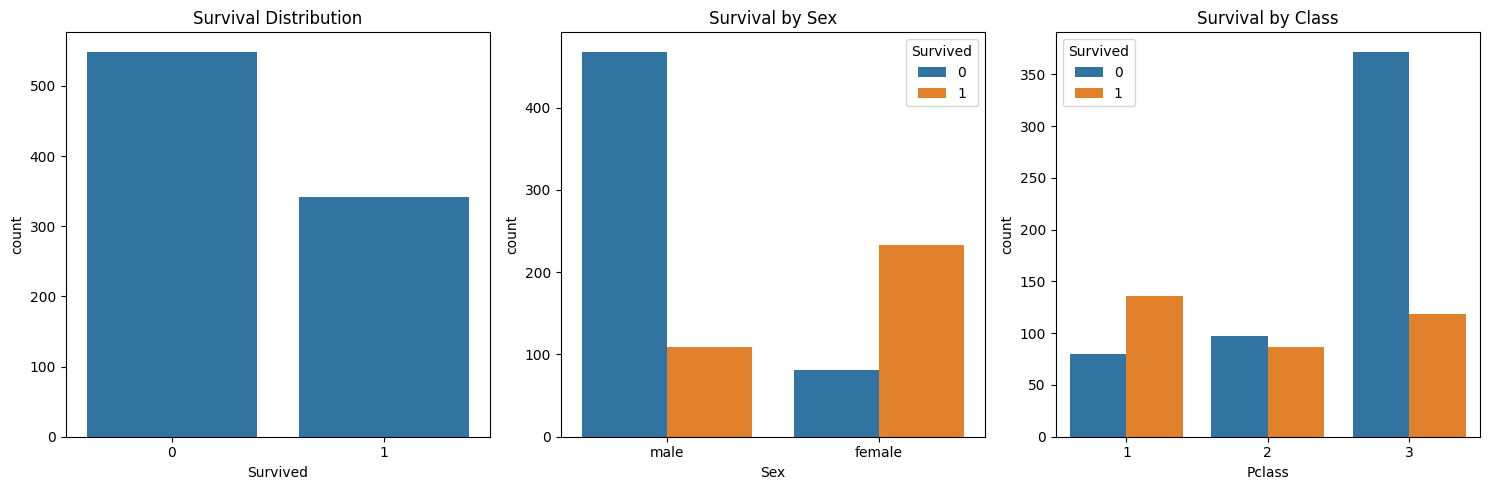

In [20]:
# Initial visualizations
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=train_data, x='Survived')
plt.title('Survival Distribution')

plt.subplot(1, 3, 2)
sns.countplot(data=train_data, x='Sex', hue='Survived')
plt.title('Survival by Sex')

plt.subplot(1, 3, 3)
sns.countplot(data=train_data, x='Pclass', hue='Survived')
plt.title('Survival by Class')
plt.tight_layout()
plt.show()


In [21]:
# Data cleaning and feature engineering function
def clean_data(df):
    df = df.copy()

    # Handle missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.')
    title_map = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Sir': 'Rare',
        'Mme': 'Mrs', 'Capt': 'Rare', 'Don': 'Rare'
    }
    df['Title'] = df['Title'].map(title_map)

    # Create family features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Create categories
    df['FareRange'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'Mid-High', 'High'])
    df['AgeGroup'] = pd.cut(df['Age'],
                           bins=[0, 12, 20, 40, 60, np.inf],
                           labels=['Child', 'Teen', 'Young', 'Mid', 'Senior'])

    return df

# Clean datasets
train_clean = clean_data(train_data)
test_clean = clean_data(test_data)


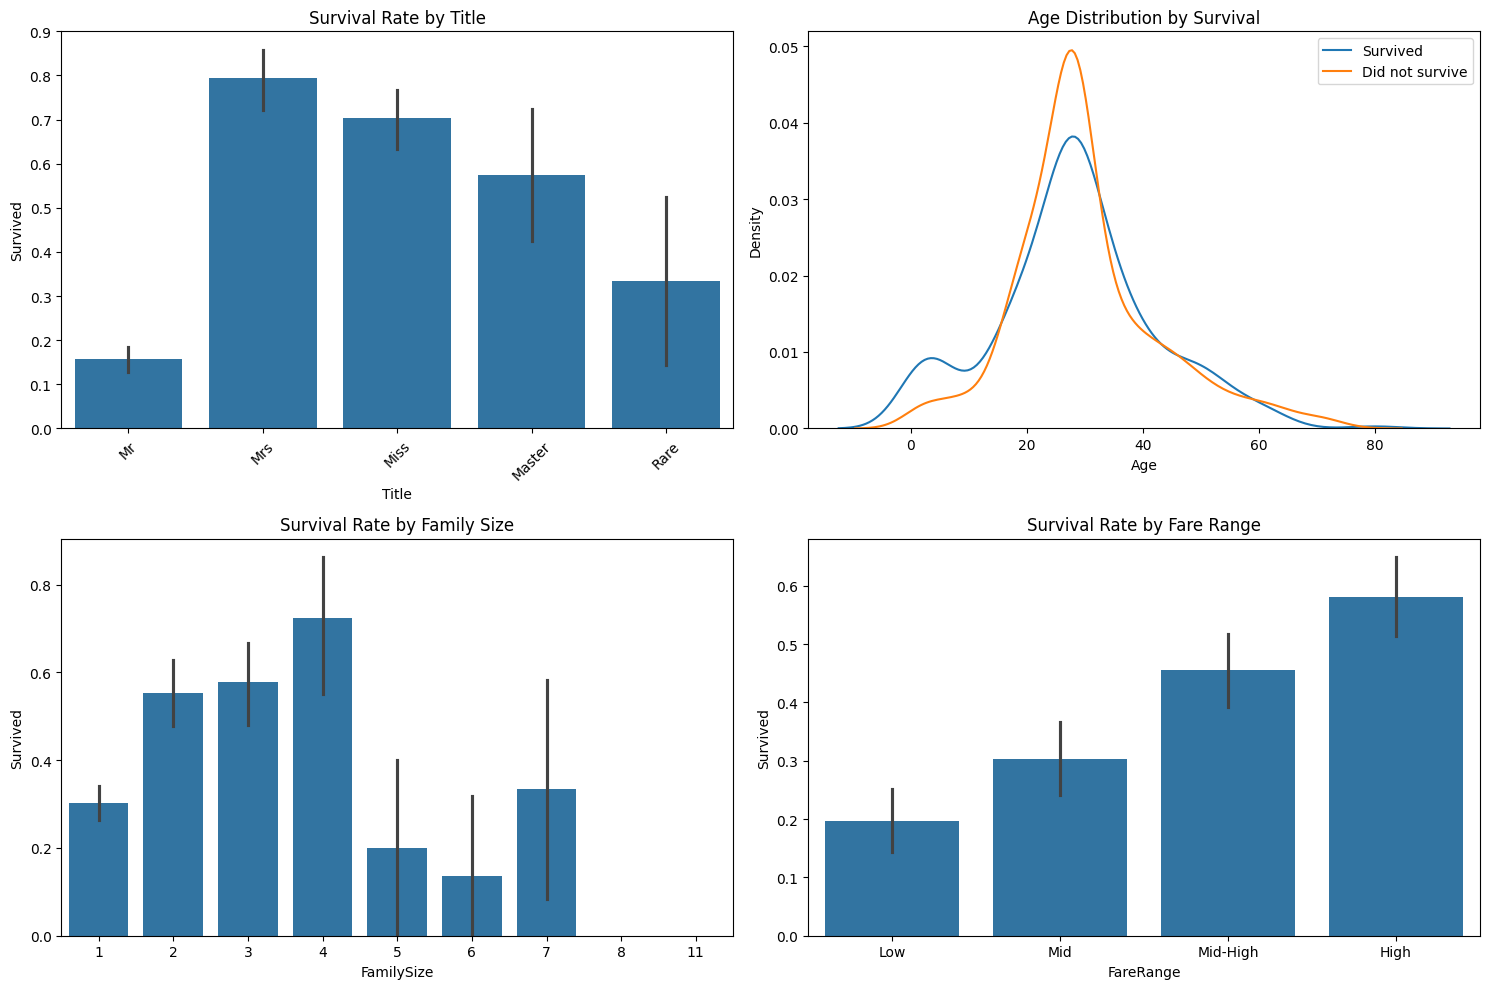

In [22]:
# Feature analysis visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Title', y='Survived', data=train_clean)
plt.title('Survival Rate by Title')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.kdeplot(data=train_clean[train_clean['Survived']==1]['Age'], label='Survived')
sns.kdeplot(data=train_clean[train_clean['Survived']==0]['Age'], label='Did not survive')
plt.title('Age Distribution by Survival')
plt.legend()

plt.subplot(2, 2, 3)
sns.barplot(x='FamilySize', y='Survived', data=train_clean)
plt.title('Survival Rate by Family Size')

plt.subplot(2, 2, 4)
sns.barplot(x='FareRange', y='Survived', data=train_clean)
plt.title('Survival Rate by Fare Range')

plt.tight_layout()
plt.show()


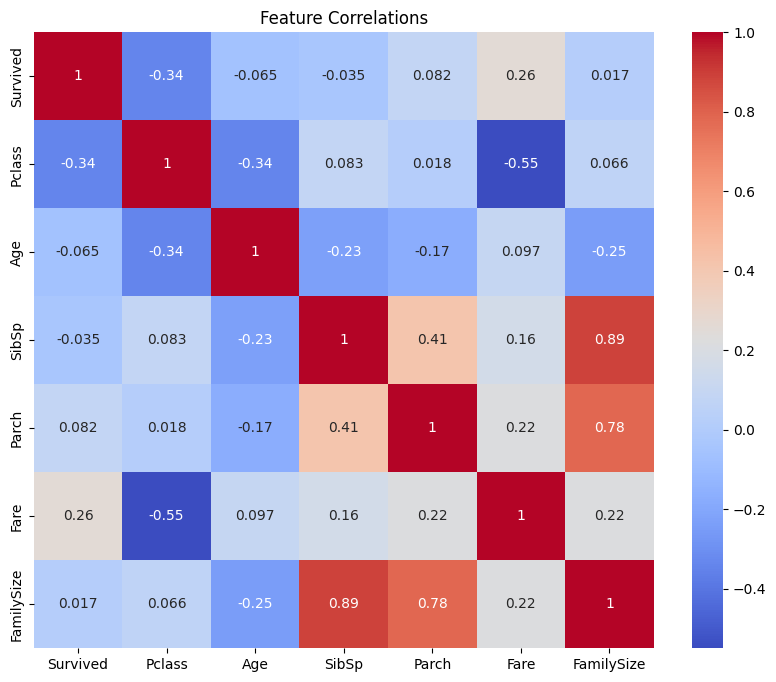

In [23]:
# Correlation analysis
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
plt.figure(figsize=(10, 8))
sns.heatmap(train_clean[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


In [24]:
# Prepare data for modeling
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
X = train_clean[features]
y = train_clean['Survived']

numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [25]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# training and evaluating multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"CV Average: {cv_scores.mean():.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



Logistic Regression Results:
Accuracy: 0.793
CV Average: 0.820

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


Random Forest Results:
Accuracy: 0.832
CV Average: 0.814

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       105
           1       0.79      0.81      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179


SVM Results:
Accuracy: 0.816
CV Average: 0.828

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      

In [27]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Perform grid search
grid_search = GridSearchCV(rf_pipeline, rf_params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print(f"Best CV Score: {grid_search.best_score_:.3f}")



Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV Score: 0.833
